In [1]:
import tensorflow as tf
import input_data
import numpy as np
import random

In [2]:
def get_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

Input Layer

In [3]:
X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 10])

# Dropout
keep_prob = tf.placeholder(tf.float32)

Convolutional Layer + Pooling #1

In [4]:
w     = get_weights([3, 3, 1, 32])
conv1 = tf.nn.relu(tf.nn.conv2d(X, w, strides=[1, 1, 1, 1], padding='SAME'))             # shape=(?, 28, 28, 32)
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # shape=(?, 14, 14, 32)
drop1 = tf.nn.dropout(pool1, keep_prob)

Convolutional Layer + Pooling #2

In [5]:
w     = get_weights([3, 3, 32, 64])
conv2 = tf.nn.relu(tf.nn.conv2d(drop1, w, strides=[1, 1, 1, 1], padding='SAME'))         # shape=(?, 14, 14, 64)
pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # shape=(?, 7, 7, 64)
drop2 = tf.nn.dropout(pool2, keep_prob)

Fully Connected Layer

In [6]:
w        = get_weights([7*7*64, 625])
reshaped = tf.reshape(drop2, [-1, 7*7*64]) # shape=(?, 4*4*128)
fullycon = tf.nn.relu(tf.matmul(reshaped, w))
drop3    = tf.nn.dropout(fullycon, keep_prob)

Output Layer

In [7]:
w          = get_weights([625, 10])
output     = tf.matmul(drop3, w)
predict_op = tf.argmax(output, 1)

Loss

In [8]:
loss       = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, Y))
accuracy   = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output, 1), tf.argmax(Y, 1)), tf.float32))
train_op   = tf.train.AdamOptimizer().minimize(loss)

Get some data

In [9]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Validation split
valid_ratio = float(10)/55
train_pairs = zip(mnist.train.images, mnist.train.labels)
random.shuffle(train_pairs)
train_X, train_Y = zip(*train_pairs[int(valid_ratio*len(train_pairs)):])
valid_X, valid_Y = zip(*train_pairs[:int(valid_ratio*len(train_pairs))])

# Test pairs
test_X, test_Y = mnist.test.images, mnist.test.labels

# Reshape
train_X = np.array(train_X).reshape(-1, 28, 28, 1)  # 28x28x1 images
valid_X = np.array(valid_X).reshape(-1, 28, 28, 1)  # 28x28x1 images
test_X  = test_X.reshape(-1, 28, 28, 1)   # 28x28x1 images

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
print 'Training:', len(train_X)
print 'Validation:', len(valid_X)
print 'Test:', len(test_X)

Training: 45000
Validation: 10000
Test: 10000


Training

In [11]:
batch_size = 64

In [12]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

for i in range(20):
    train_loss = []
    valid_loss = []
    valid_acc  = []
    test_loss  = []
    test_acc   = []

    for j in range(len(train_X)/batch_size):
        start = j * batch_size
        end   = (j+1) * batch_size
        loss_, _ = sess.run([loss, train_op], feed_dict={X: train_X[start:end], Y: train_Y[start:end], keep_prob: 0.8})

        train_loss.append(loss_)
        
        if j > 0 and j % 100 == 0:
            print ('Step %d: ' % j), np.mean(train_loss[(j-100):j])

    for j in range(len(valid_X)/batch_size):
        start = j * batch_size
        end   = (j+1) * batch_size
        loss_, acc_ = sess.run([loss, accuracy], feed_dict={X: valid_X[start:end], Y: valid_Y[start:end], keep_prob: 1.0})

        valid_loss.append(loss_)
        valid_acc.append(acc_)

    for j in range(len(test_X)/batch_size):
        start = j * batch_size
        end   = (j+1) * batch_size
        loss_, acc_ = sess.run([loss, accuracy], feed_dict={X: test_X[start:end], Y: test_Y[start:end], keep_prob: 1.0})

        test_loss.append(loss_)
        test_acc.append(acc_)

    print 'End of epoch %d:' % (i+1)
    print 'Training loss:', np.mean(train_loss), \
          'Validation loss:', np.mean(valid_loss), \
          'Test loss:', np.mean(test_loss)
    print ('Validation accuracy: %g%%' % (np.mean(valid_acc) * 100)), \
          ('Test accuracy: %g%%' % (np.mean(test_acc) * 100))
    print

Step 100:  0.938519
Step 200:  0.356716
Step 300:  0.224322
Step 400:  0.211896
Step 500:  0.165853
Step 600:  0.16777
Step 700:  0.13493
End of epoch 1:
Training loss: 0.313605 Validation loss: 0.10713 Test loss: 0.100931
Validation accuracy: 96.5244% Test accuracy: 96.8049%

Step 100:  0.145502
Step 200:  0.125464
Step 300:  0.114705
Step 400:  0.115172
Step 500:  0.0941064
Step 600:  0.098099
Step 700:  0.0881787
End of epoch 2:
Training loss: 0.11152 Validation loss: 0.063265 Test loss: 0.059497
Validation accuracy: 97.9367% Test accuracy: 98.0669%

Step 100:  0.0857653
Step 200:  0.0851376
Step 300:  0.0774498
Step 400:  0.080694
Step 500:  0.0711153
Step 600:  0.0710368
Step 700:  0.0661157
End of epoch 3:
Training loss: 0.0766571 Validation loss: 0.046273 Test loss: 0.0420134
Validation accuracy: 98.5377% Test accuracy: 98.6278%

Step 100:  0.066796
Step 200:  0.060172
Step 300:  0.0531665
Step 400:  0.060895
Step 500:  0.0477052
Step 600:  0.0576722
Step 700:  0.0494426
End of 

# Demonstration

In [13]:
from matplotlib.pyplot import imshow

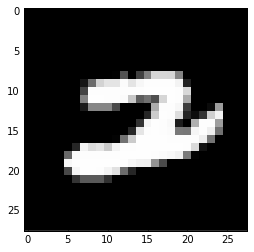

In [18]:
%matplotlib inline
# Input
this_input, this_label = random.sample(zip(test_X, test_Y), 1)[0]
label = sess.run(predict_op, feed_dict={X: [this_input], Y: [np.zeros_like(this_label)], keep_prob: 1.0})
imshow(np.reshape(this_input, (28, 28)), interpolation='none', cmap='Greys_r')

In [19]:
print label[0]

2
